In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import ruptures as rpt

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
from scipy import interpolate
import astropy.stats as astro_stats
from scipy.optimize import curve_fit
from astropy.io import ascii
from scipy.signal import find_peaks
import scipy.integrate as integrate
from scipy.signal import savgol_filter


# generate signal
n_samples, dim, sigma = 1000, 1, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

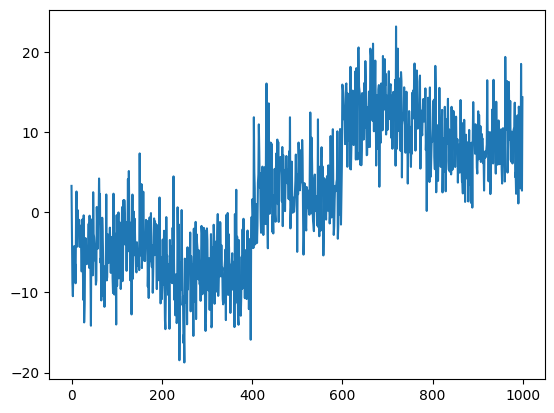

In [8]:
plt.plot(signal.T[0])

In [9]:
# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

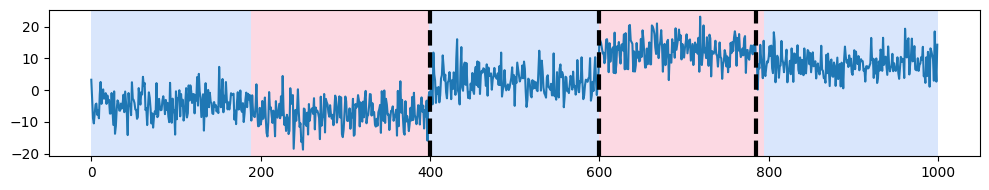

In [10]:
rpt.display(signal, bkps, result)
plt.show()

In [14]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def variation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag_err), astro_stats.biweight_scale(mag_err)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)    


def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy) - 0.011*np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + 1*np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1


def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6, peak_close_rmv=15):
    
    yht = savgol_filter(dips, 11, 8) # try savgol smoothing...
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(yht, height=loc_peak_thresh, distance=500)

    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    if len(pks)>1:
        # remove peaks that are too close to each other
        t_pks = np.array([t_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                             t_pks[i+1],
                                                                             atol=peak_close_rmv)]) # 5 day tolerance window...

        p_pks = np.array([p_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                            t_pks[i+1],
                                                                            atol=peak_close_rmv)])
        srt = np.argsort(t_pks) # argsort the t_pks

        t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1
    
    return N_peaks, dip_summary

In [15]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/331210100140458")

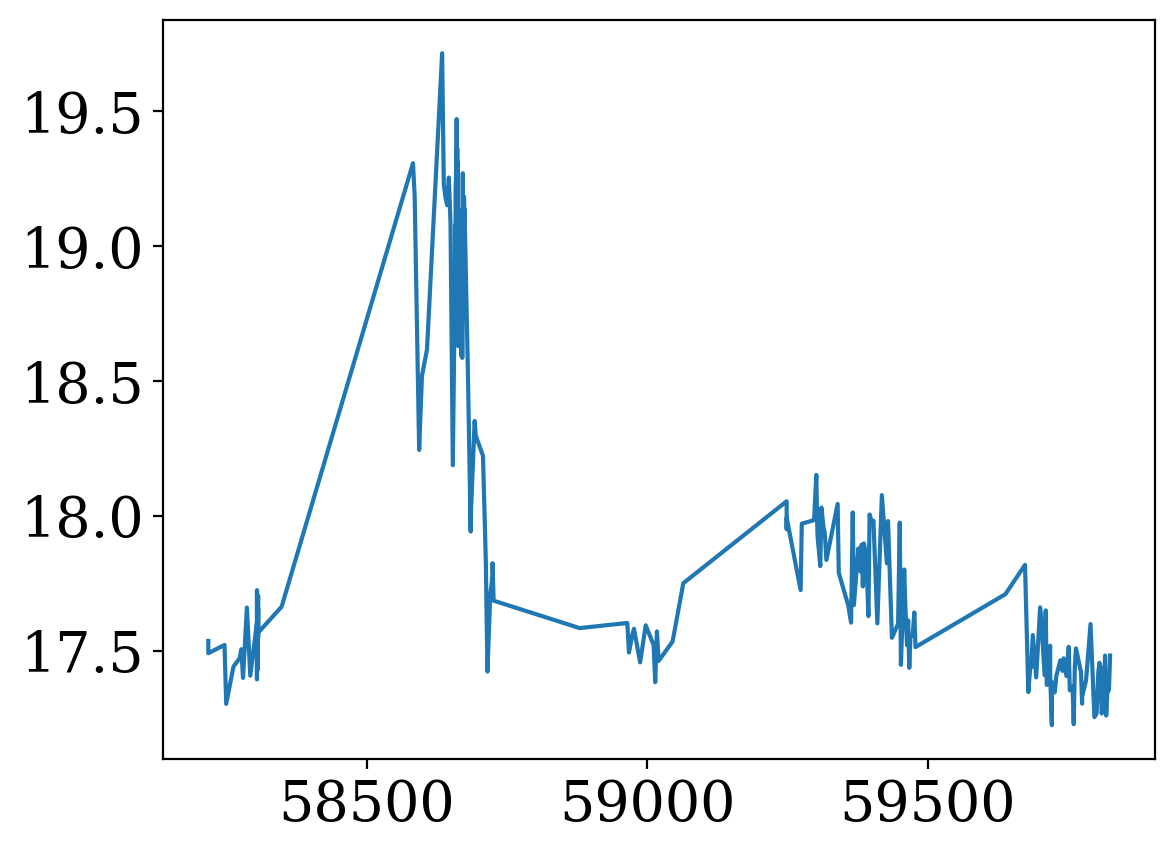

In [16]:
plt.plot(lc['mjd'], lc['mag'])

In [37]:
X = lc['mag'].data.reshape(-1, 1)
Y = lc['mjd'].data.reshape(-1, 1)


In [38]:
# detection
algo = rpt.Pelt(model="rbf").fit(X)
result = algo.predict(pen=10)


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

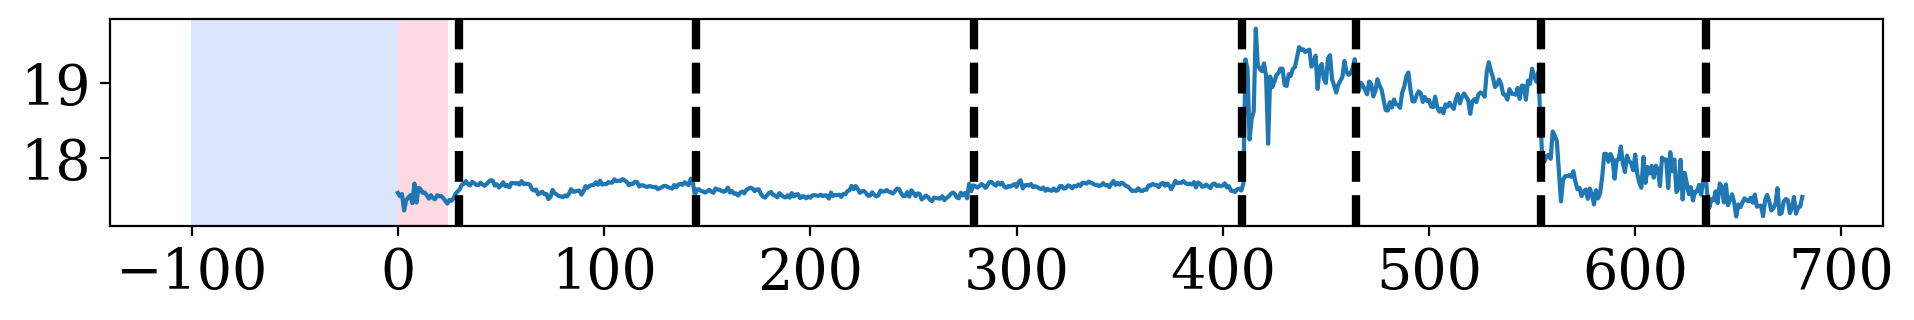

In [39]:
rpt.display(X, [-100, 25], result, )

30
145
280
410
465
555
635
682


IndexError: index 682 is out of bounds for axis 0 with size 682

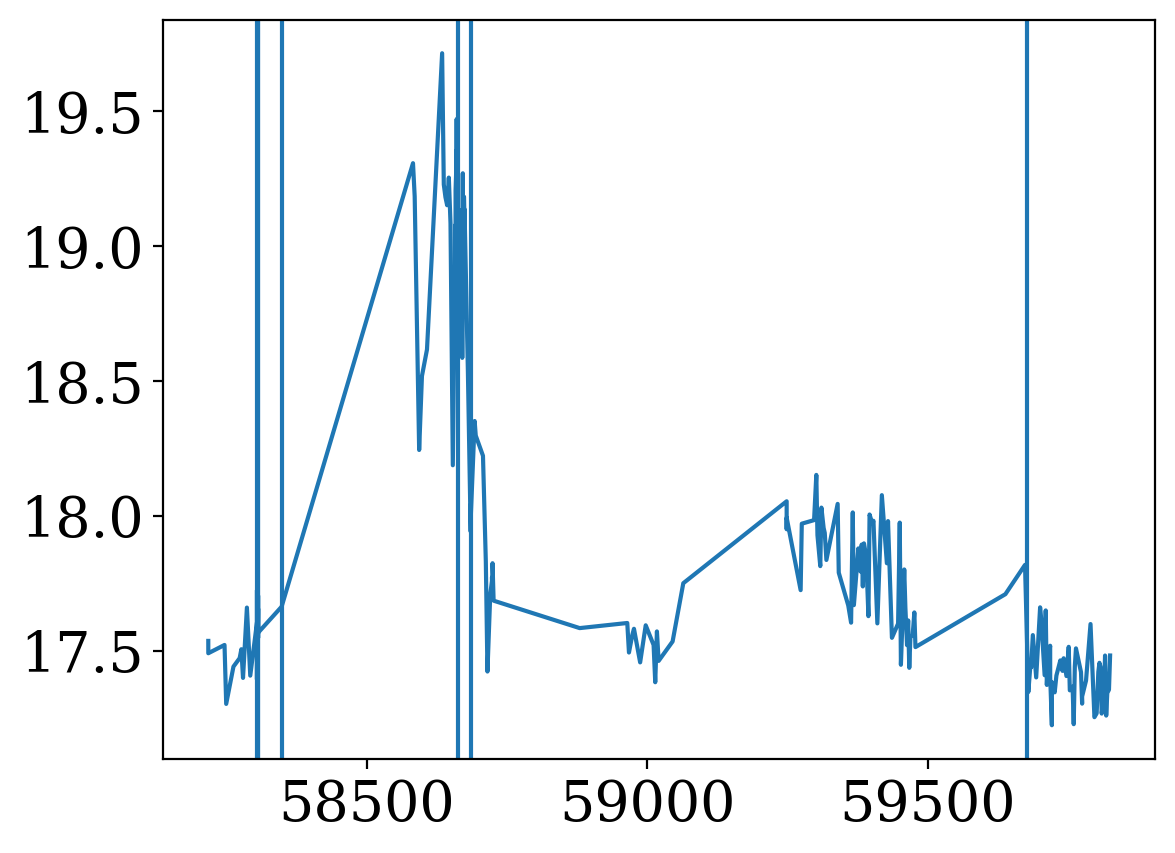

In [40]:
plt.plot(Y, X)
for res in result:
    print (res)
    plt.axvline(Y[res])

In [165]:
N = 250 # number of detections
time = np.random.randint(100, 10_000, N) + np.random.normal(0, 1750, N)
ts = np.argsort(time)
time = time[ts]

line = lambda x, a, b: x*a + b
dip = lambda x, a, b, c: a*np.exp(-((x-b)**2)/(2*c**2))

mr = np.zeros(N) + 16 + np.random.normal(0, 0.003, N) + dip(time, 0.1, 6_000, 150)
mr_err = line(mr, 0.0001, 1e-3)


In [166]:
algo = rpt.Pelt(model="rbf").fit(mr.reshape(-1, 1))
result = algo.predict(pen=5)

In [167]:
result

[130, 145, 250]

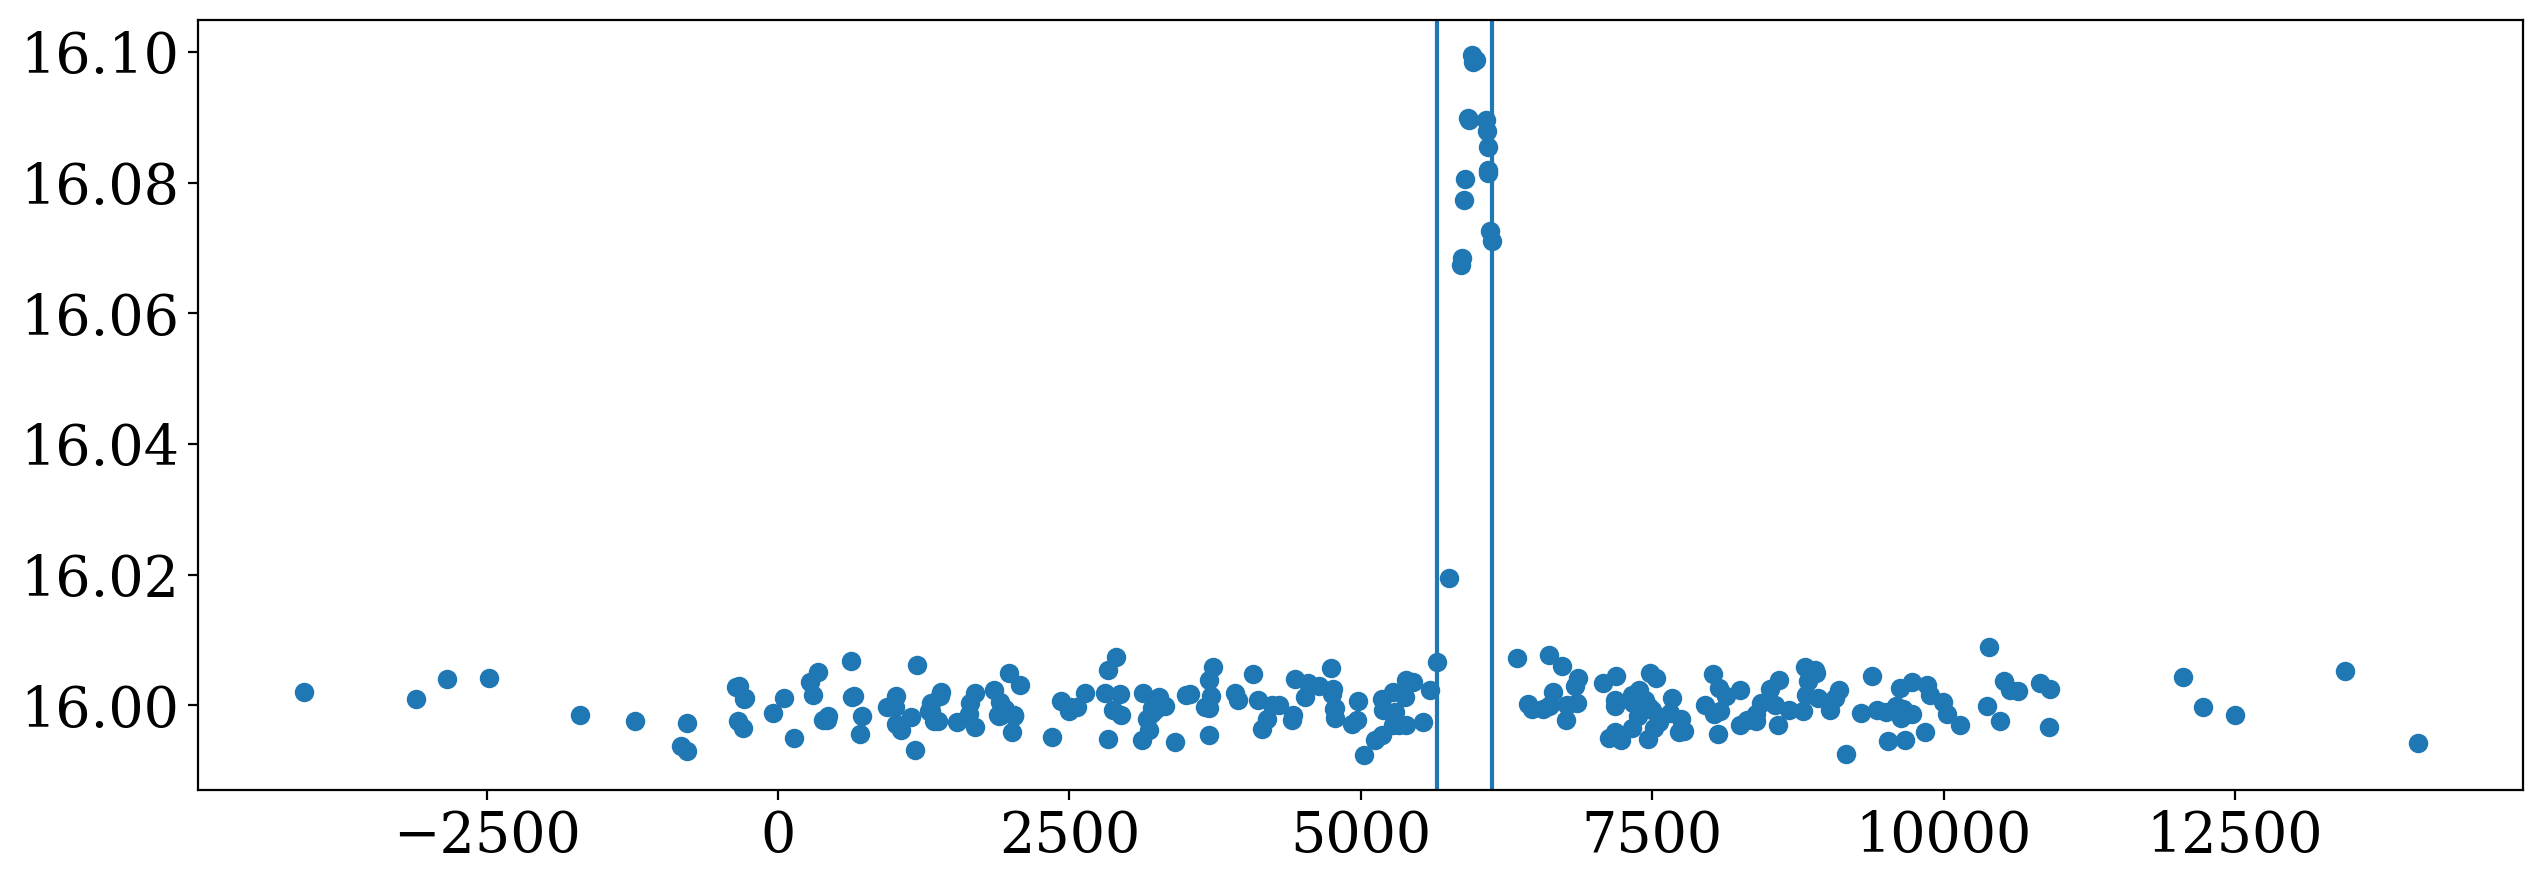

In [169]:
plt.figure(figsize=(15,5))
plt.scatter(time, mr)
plt.axvline(time[130-1])
plt.axvline(time[145+1])


In [170]:
def find_dip(pulls):
    """Find the longest sequence of significant observations in the data"""
    significant = pulls > 3.

    if np.sum(significant) == 0:
        return 0, 0

    # Find indices of start and end of each significant sequence
    changes = np.diff(np.hstack(([False], significant, [False])))
    significant_sequences = np.where(changes)[0].reshape(-1, 2)

    # Find the index of the longest sequence
    longest_idx = np.argmax(np.diff(significant_sequences, axis=1))
    seq_start, seq_end = significant_sequences[longest_idx]

    return seq_start, seq_end

In [171]:
dd = deviation(mr, mr_err)

In [172]:
find_dip(dd)

(130, 147)

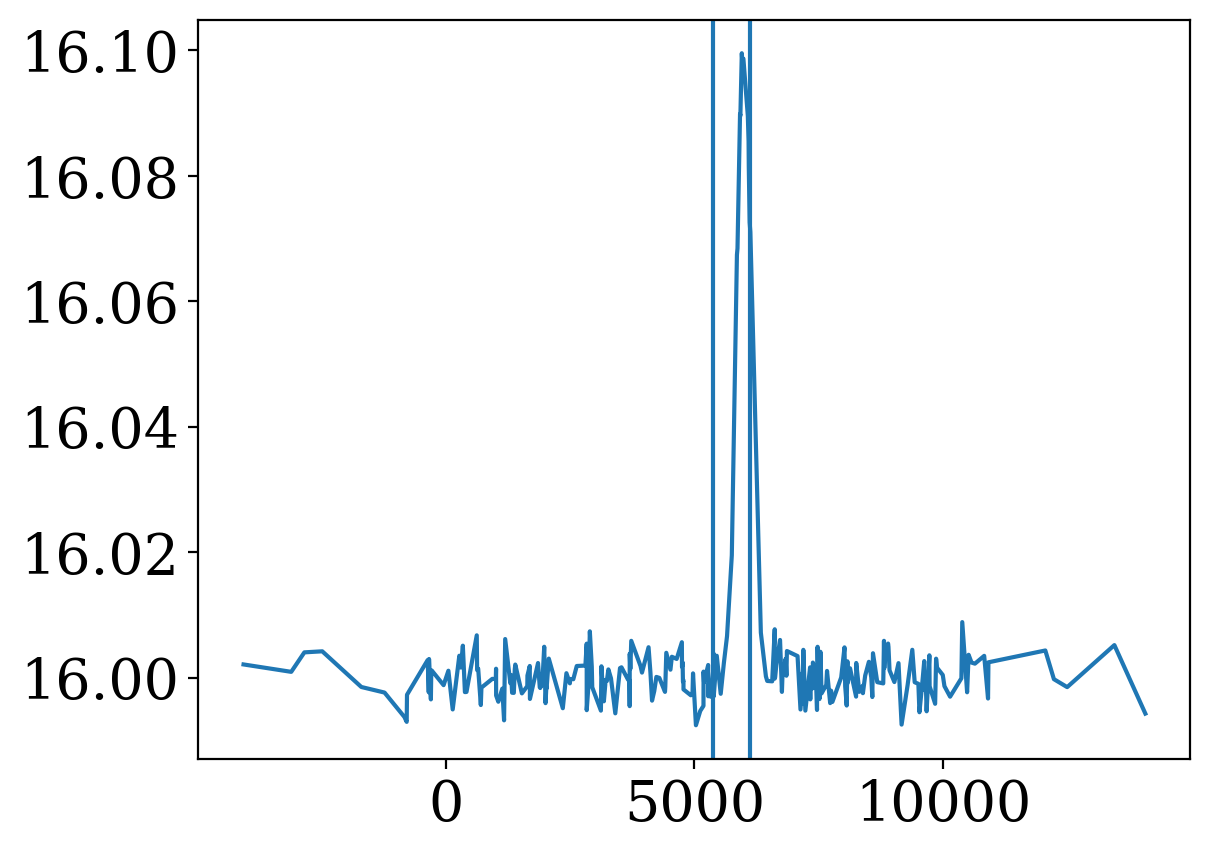

In [173]:
plt.axvline(time[124])
plt.axvline(time[146])
plt.plot(time, mr)


In [174]:
time[np.argmax(mr)]

5953.686696595514

In [176]:
calc_dip_edges(time, mr, 5953.686696595514)

(6336.6764273188155, 5752.83721580945, 382.98973072330136, 16)

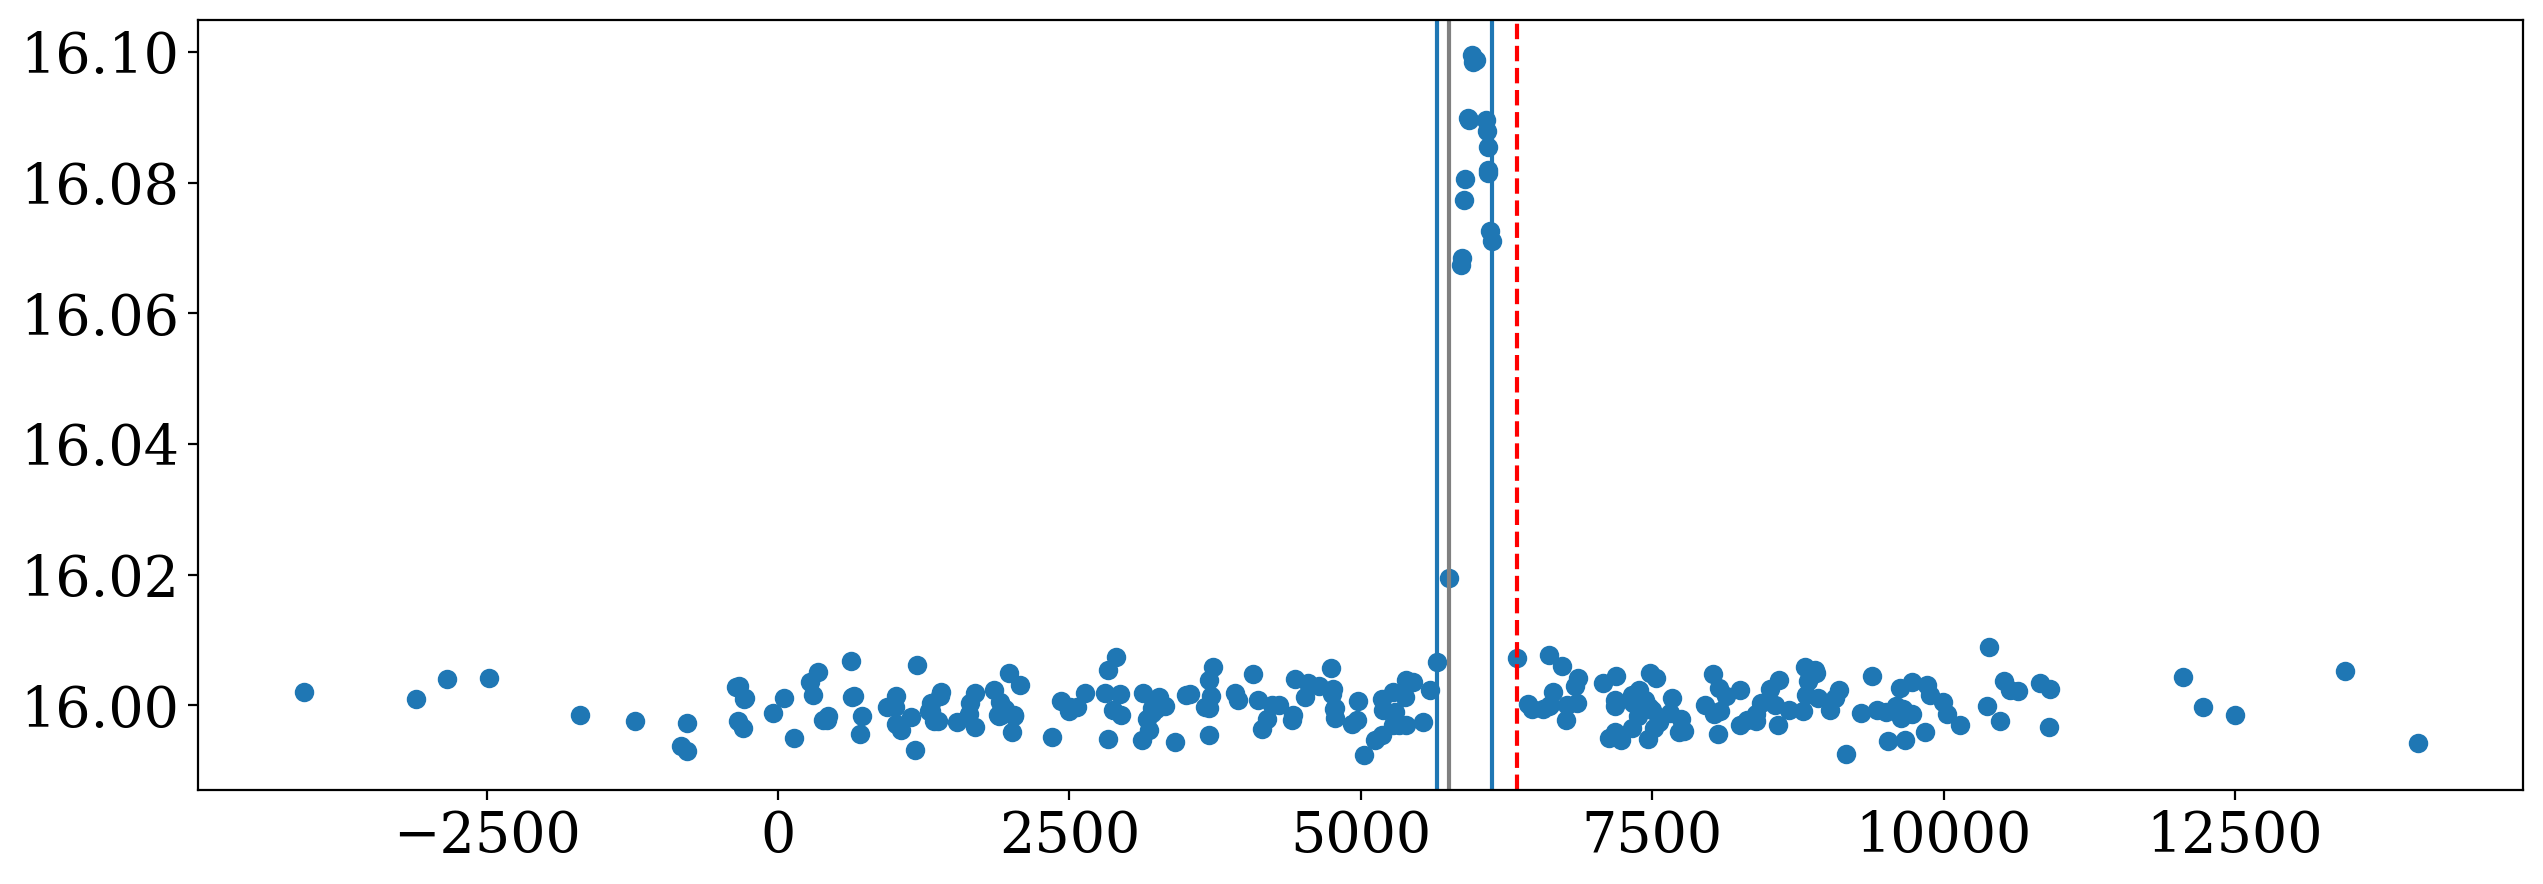

In [177]:
plt.figure(figsize=(15,5))
plt.axvline(time[130-1])
plt.axvline(time[145+1])
plt.scatter(time, mr)

plt.axvline(6336.6764273188155, color='red', ls='--')
plt.axvline(5752.83721580945, color='gray')